# CNN model to analyze Lund Images
* Lund images have prepared to have the dimensions (N_events, 25,25,1)

In [1]:
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm 
from keras.datasets import mnist, fashion_mnist,cifar10
from tensorflow.keras.utils import plot_model
import sklearn
from keras import backend as K # The backend is important while we are dealing with keras layers and the basic low level operation cannot be handeled by numpy
from keras.losses import mse, binary_crossentropy,CategoricalCrossentropy
from tqdm import tqdm  
import random    
# Import all the required Libraries
from sklearn.metrics import  roc_curve,auc
import tensorflow
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten,  Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras import regularizers
import os
from scipy.ndimage import gaussian_filter

from keras_nlp.layers import TransformerEncoder 
from matplotlib.colors import LogNorm
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

if not tf.test.gpu_device_name():
    warnings.warn('No GPU found.....')
    sys.exit()
else:
    print('Default GPU device :{}'.format(tf.test.gpu_device_name()))
    
    

Using TensorFlow backend
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Default GPU device :/device:GPU:0


In [2]:
## function to flatten list of lists #######
def flatten(t):
    return np.array([item for sublist in t for item in sublist])

In [3]:
#### load the Lund images ###### 
Images_SM = np.load('/Users/hammad/work/Lund/data/data_images/Images_SM.npz',allow_pickle=True)['arr_0']
Images_sig = np.load('/Users/hammad/work/Lund/data/data_images/Images_sig.npz',allow_pickle=True)['arr_0']

In [4]:
im_SM = flatten(Images_SM)
im_sig = flatten(Images_sig)

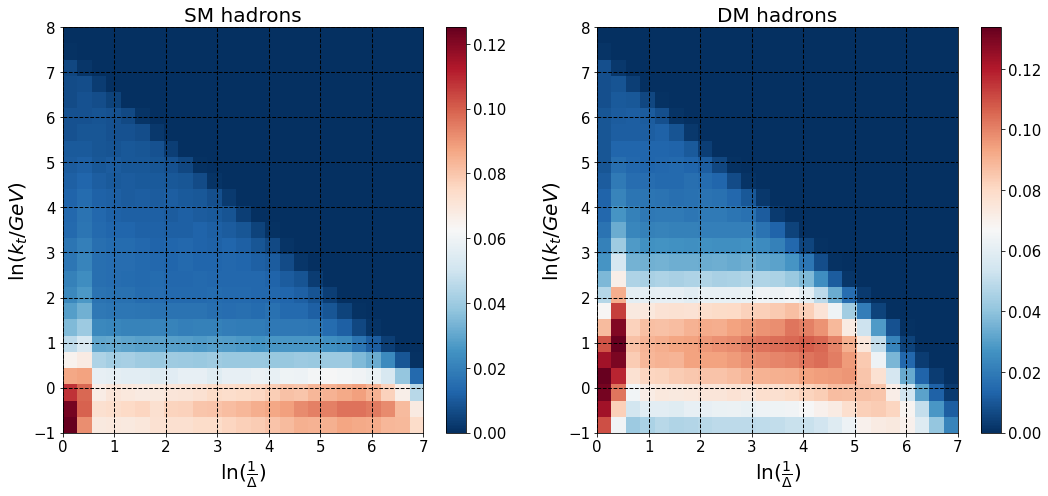

In [5]:
## Plot Lund Images for the SM and the DM
xval = [0,7]
yval = [-1,8]
fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(hspace=1, wspace=1)
y1 = fig.add_subplot(121)
c1=y1.imshow(np.average(im_SM[:90000],axis=0).T,origin='lower',aspect='auto',extent=xval+yval,cmap='RdBu_r')
y1.set_title(r'SM hadrons',fontsize=20)
y1.set_xlabel(r'$\ln(\frac{1}{\Delta})$',fontsize=20)
y1.set_ylabel(r'$\ln(k_t/GeV)$',fontsize=20)
plt.tick_params(axis='both',labelsize=15)
plt.colorbar(c1).ax.tick_params(labelsize=15)
y1.grid(color='k',linestyle='--',linewidth=1.01)

y2 = fig.add_subplot(122)
c2=y2.imshow(np.average(im_sig[:90000],axis=0).T,origin='lower',aspect='auto',extent=xval+yval,cmap='RdBu_r')
y2.set_title(r'DM hadrons',fontsize=20)
y2.set_xlabel(r'$\ln(\frac{1}{\Delta})$',fontsize=20)
y2.set_ylabel(r'$\ln(k_t/GeV)$',fontsize=20)
plt.tick_params(axis='both',labelsize=15)
plt.colorbar(c2).ax.tick_params(labelsize=15)
y2.grid(color='k',linestyle='--',linewidth=1.01)

plt.tight_layout()
plt.savefig('Lund.png')

In [6]:
# Transpose the images to get the right dimensions
imb = []
for i in range(len(im_SM)):
    imb.append(im_SM[i].T)

ims = []
for i in range(len(im_sig)):
    ims.append(im_sig[i].T)

    
im_s=np.array(ims).reshape(im_sig.shape[0],25,25)
im_b=np.array(imb).reshape(im_SM.shape[0],25,25)


In [7]:
print(f'Signal shape: {im_s.shape},   Background shape: {im_b.shape}')

Signal shape: (99999, 25, 25),   Background shape: (99999, 25, 25)


In [8]:
# prepare the data for CNN

k =90_000
x1_data = np.concatenate((im_s[:k], im_b[:k]))
y1_data = np.array([1]*len(im_s[:k])+[0]*len(im_b[:k]))
x_data,y_data= sklearn.utils.shuffle(x1_data, y1_data) # shuffle both 

In [9]:
# Split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,shuffle=True, test_size=0.2)

In [10]:
print(f'Train shape: {X_train.shape},   Test shape: {X_test.shape}')

Train shape: (144000, 25, 25),   Test shape: (36000, 25, 25)


In [11]:
# Another reshape for the model 

x_train= np.array(X_train).reshape(np.array(X_train).shape+(1,)).astype('float32')
x_test= np.array(X_test).reshape(np.array(X_test).shape+(1,)).astype('float32')
x_train.shape,x_test.shape

((144000, 25, 25, 1), (36000, 25, 25, 1))

In [12]:
### CNN model 
inp = Input((25,25,1))
e = Conv2D(16, (3, 3), activation='relu',name = 'Conv_1')(inp)
e = Conv2D(16, (3, 3), activation='relu',name = 'Conv_2')(e)
e = MaxPooling2D((2, 2),name = 'Pooling_1')(e)
e= Dropout(0.2)(e)
e = Conv2D(32, (3, 3), activation='relu',name = 'Conv_3')(e)
e = Conv2D(32, (3, 3), activation='relu',name = 'Conv_4')(e)
e = MaxPooling2D((2, 2),name = 'Pooling_2')(e)
e= Dropout(0.2)(e)
e = Flatten()(e)
e = Dense(400, activation='relu',name = 'FC_1')(e)
e= Dropout(0.2)(e)
x=  Dense(2, activation="softmax")(e)
cnn = Model(inp,x)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 1)]       0         
                                                                 
 Conv_1 (Conv2D)             (None, 23, 23, 16)        160       
                                                                 
 Conv_2 (Conv2D)             (None, 21, 21, 16)        2320      
                                                                 
 Pooling_1 (MaxPooling2D)    (None, 10, 10, 16)        0         
                                                                 
 dropout (Dropout)           (None, 10, 10, 16)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 8, 8, 32)          4640      
                                                                 
 Conv_4 (Conv2D)             (None, 6, 6, 32)          9248  

In [13]:
### Compile the model and fit ###
cnn.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005), metrics=['accuracy'])
history_cnn = cnn.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=100,shuffle=True, verbose=1)


Epoch 1/10
1296/1296 [==============================] - 14s 8ms/step - loss: 0.2033 - accuracy: 0.9154 - val_loss: 0.2261 - val_accuracy: 0.9060
Epoch 2/10
1296/1296 [==============================] - 10s 8ms/step - loss: 0.1786 - accuracy: 0.9296 - val_loss: 0.1779 - val_accuracy: 0.9317
Epoch 3/10
1296/1296 [==============================] - 10s 8ms/step - loss: 0.1745 - accuracy: 0.9309 - val_loss: 0.1720 - val_accuracy: 0.9326
Epoch 4/10
1296/1296 [==============================] - 10s 8ms/step - loss: 0.1726 - accuracy: 0.9324 - val_loss: 0.1798 - val_accuracy: 0.9310
Epoch 5/10
1296/1296 [==============================] - 10s 8ms/step - loss: 0.1755 - accuracy: 0.9307 - val_loss: 0.1749 - val_accuracy: 0.9304
Epoch 6/10
1296/1296 [==============================] - 10s 8ms/step - loss: 0.1781 - accuracy: 0.9298 - val_loss: 0.1746 - val_accuracy: 0.9322
Epoch 7/10
1296/1296 [==============================] - 10s 8ms/step - loss: 0.1834 - accuracy: 0.9288 - val_loss: 0.1816 - val_ac

In [14]:
## Plot the accuracy history #####

pd.DataFrame(history_cnn.history).plot(logy=True);

In [15]:
scores = cnn.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (cnn.metrics_names[1], scores[1]*100))

accuracy: 92.80%


In [16]:
score=cnn.predict(x_test);
fpr, tpr,_ =roc_curve(tf.keras.utils.to_categorical(y_test,2).ravel(),score.ravel());


1125/1125 [==============================] - 2s 1ms/step


In [17]:
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1],'k--',linewidth=1);
plt.plot(fpr,tpr,linewidth=2,label=r'$AUC$= {:.2f}%'.format(float(auc(fpr, tpr))*100));
plt.xlabel(r'False Positive',fontsize=20,c='k');
plt.ylabel(r'True positive rate',fontsize=20,c='k');
plt.grid(linestyle='--',c='k')
plt.legend(loc='best',fontsize=15);
plt.tick_params(axis='both',labelsize=15)
plt.tight_layout()

In [18]:
np.savetxt('fpr_Lund_CNN.txt',fpr);
np.savetxt('tpr_Lund_CNN.txt',tpr);

In [19]:
%pwd

'/Users/hammad/work/Lund/codes_ML'